In [ ]:
# importing the libraries
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/Shareddrives/ShupponKu/split-output-wsample.zip'

In [ ]:
data_dir = '/content/split-output/'

In [ ]:
train_folder= os.path.join(data_dir,'train')
valid_folder= os.path.join(data_dir,'val')
sample_folder= os.path.join(data_dir,'sample')
test_folder= os.path.join(data_dir,'test')
num_of_training_img = len(os.listdir(train_folder + '/images')) 
num_of_training_mask = len(os.listdir(train_folder + '/masks'))
num_of_val_img = len(os.listdir(valid_folder + '/images'))
num_of_test_img = len(os.listdir(test_folder + '/images'))

In [ ]:
print(f"There are {num_of_training_img} images.\n")
print(f"There are {num_of_training_mask} masks.\n")

There are 4086 images.

There are 4086 masks.



--BATAS SUCI--

In [ ]:
train_dir=train_folder
val_dir=valid_folder
test_dir=test_folder
sample_dir = sample_folder

In [ ]:
img_dim = 256
BATCH_SIZE = 32 
seed = 42

In [ ]:
from PIL import Image
import random
import seaborn as sns

In [ ]:
tr_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_image_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,
)
    
train_mask_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

val_image_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
val_mask_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
test_image_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
test_mask_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
sam_image_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
sam_mask_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)
sample_generator = zip(sam_image_generator, sam_mask_generator)

Found 4086 images belonging to 1 classes.
Found 4086 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [ ]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

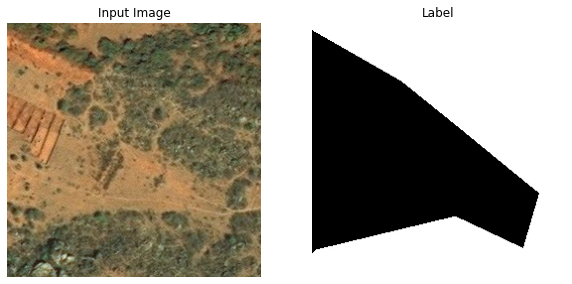

In [ ]:
num_sample = 1
n = 0
# print(train_image_generator.shape)
for image, mask in sample_generator:
    sample_image, sample_label = image[0], mask[0]
    if n < num_sample:
        display([sample_image, sample_label])
        n+=1
    else:
        break

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [ ]:
def fcn(image_size, ch_in=3, ch_out=1):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(f5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

    conv_8 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_8")(f4)
    conv_9 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_9")(f3)
    
    deconv_7 = Conv2DTranspose(1024, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])

    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=16,
                              padding='same', activation="sigmoid")(add_1)
                              
    # outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(deconv)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    fsum = K.sum(y_true,[1,2,3])
    ssum = K.sum(y_pred,[1,2,3])
    dice = (2 * intersect + smooth) / (fsum + ssum + smooth)
    dice = K.mean(dice)
    return dice  

def iou_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# defining the tensorflow distribute strategy
# strategy = tf.distribute.MirroredStrategy()

In [ ]:
# # calling the model inside the scope
# with strategy.scope():
model = fcn((img_dim, img_dim))
# compiling the model with the optimizer, loss function and acc metrics
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[iou_coef,dice_coef,'accuracy', 'mse'])

58889256/58889256 [==============================] - 0s 0us/step


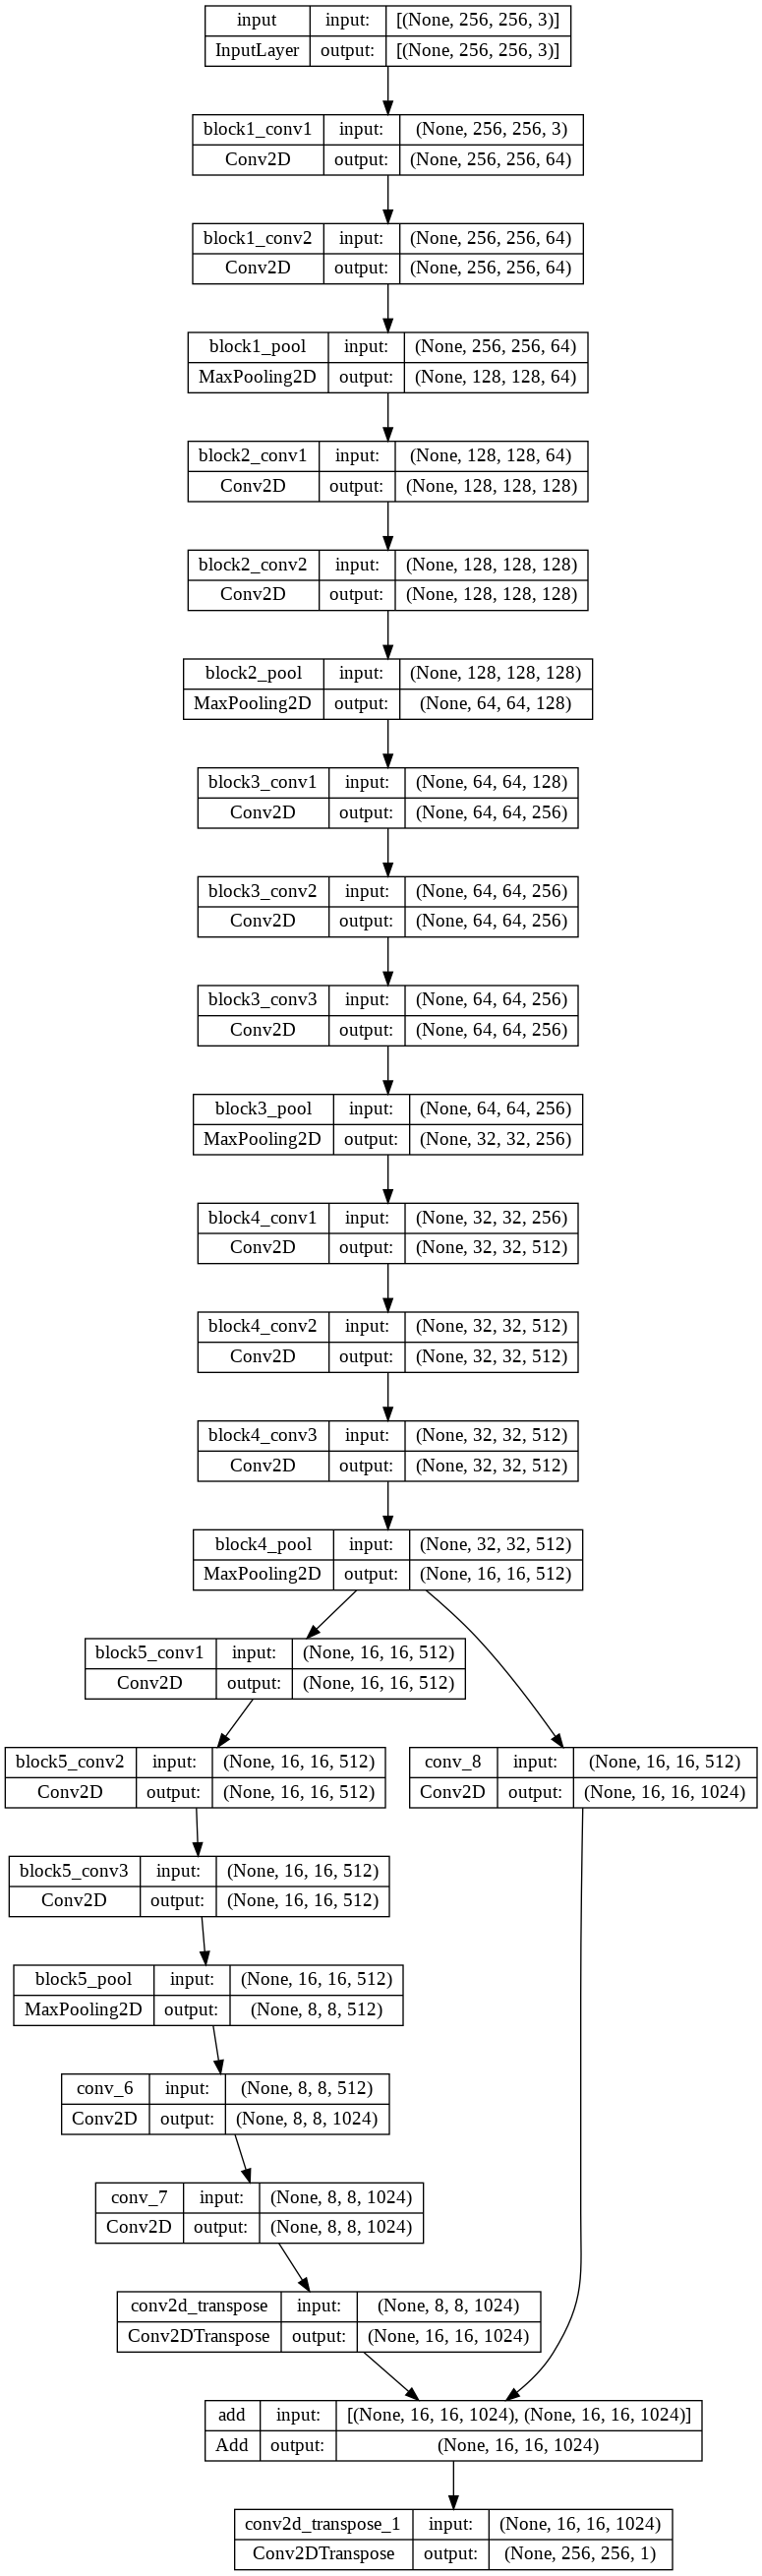

In [ ]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    n = 0
    for image, mask in dataset:
      image, mask = image, mask
      if n < num:
        # pred_mask = model.predict(image)
        result = model.predict(image)
        output = result[0]
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        print(f'image shape {image.shape}')
        print(f'mask shape {mask.shape}')
        print(f'pred_mask shape {output.shape}')
        display([image[0], mask[0], output])
        n+=1
      else:
        break
  else:
    result = model.predict(sample_image[tf.newaxis, ...])
    output = result[0]
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    display([sample_image, sample_label, output])

1/1 [==============================] - 0s 38ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (256, 256, 1)


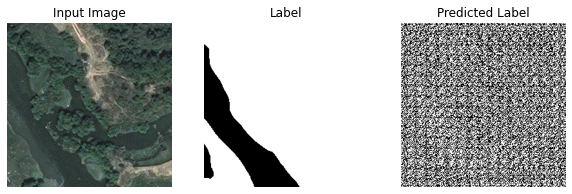

In [ ]:
# # Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions(test_generator)

In [ ]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1)


Epoch 1/50
1/1 [==============================] - 1s 789ms/step


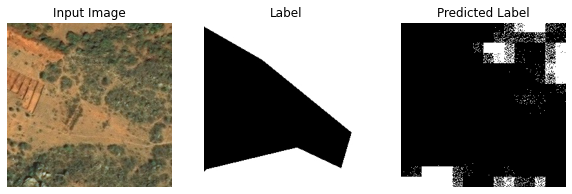


Sample Prediction after epoch 1

127/127 [==============================] - 115s 855ms/step - loss: 0.6841 - iou_coef: 0.5414 - dice_coef: 0.6198 - accuracy: 0.5754 - mse: 0.2432 - val_loss: 0.6677 - val_iou_coef: 0.4720 - val_dice_coef: 0.5472 - val_accuracy: 0.6877 - val_mse: 0.2372 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 17ms/step


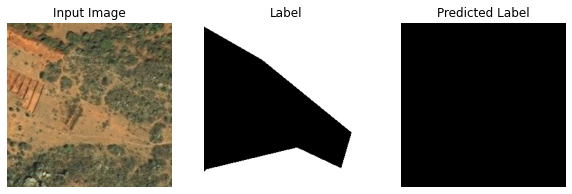


Sample Prediction after epoch 2

127/127 [==============================] - 115s 853ms/step - loss: 0.6847 - iou_coef: 0.5505 - dice_coef: 0.6282 - accuracy: 0.5816 - mse: 0.2417 - val_loss: 0.6741 - val_iou_coef: 0.6199 - val_dice_coef: 0.7019 - val_accuracy: 0.6133 - val_mse: 0.2404 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 19ms/step


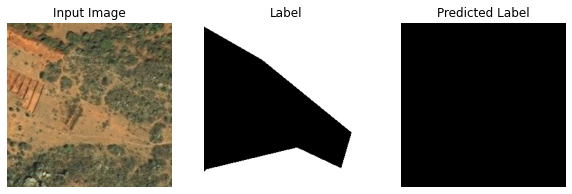


Sample Prediction after epoch 3

127/127 [==============================] - 107s 845ms/step - loss: 0.6734 - iou_coef: 0.6001 - dice_coef: 0.6814 - accuracy: 0.5908 - mse: 0.2388 - val_loss: 0.6698 - val_iou_coef: 0.6199 - val_dice_coef: 0.7019 - val_accuracy: 0.6133 - val_mse: 0.2383 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 27ms/step


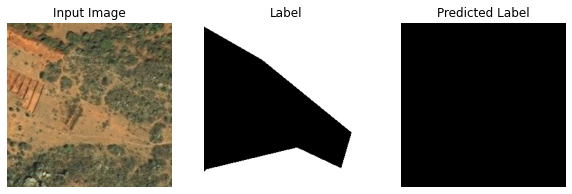


Sample Prediction after epoch 4

127/127 [==============================] - 108s 854ms/step - loss: 0.6498 - iou_coef: 0.5823 - dice_coef: 0.6657 - accuracy: 0.6152 - mse: 0.2248 - val_loss: 0.6489 - val_iou_coef: 0.6199 - val_dice_coef: 0.7019 - val_accuracy: 0.6133 - val_mse: 0.2280 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 18ms/step


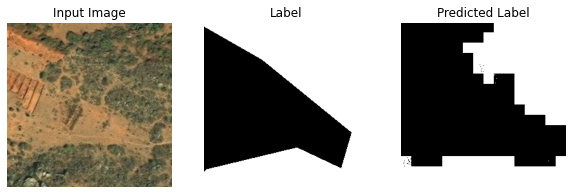


Sample Prediction after epoch 5

127/127 [==============================] - 108s 851ms/step - loss: 0.6260 - iou_coef: 0.5837 - dice_coef: 0.6678 - accuracy: 0.6740 - mse: 0.2113 - val_loss: 0.6134 - val_iou_coef: 0.4977 - val_dice_coef: 0.5852 - val_accuracy: 0.7046 - val_mse: 0.2060 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 0s 16ms/step


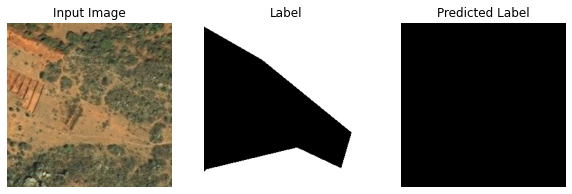


Sample Prediction after epoch 6

127/127 [==============================] - 106s 839ms/step - loss: 0.6558 - iou_coef: 0.5879 - dice_coef: 0.6701 - accuracy: 0.6144 - mse: 0.2297 - val_loss: 0.5881 - val_iou_coef: 0.6199 - val_dice_coef: 0.7019 - val_accuracy: 0.6133 - val_mse: 0.2016 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 0s 18ms/step


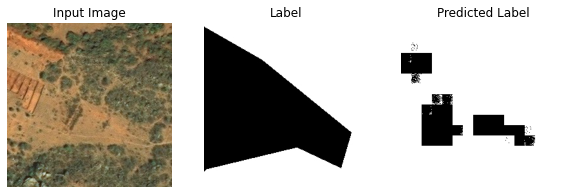


Sample Prediction after epoch 7

127/127 [==============================] - 108s 849ms/step - loss: 0.6035 - iou_coef: 0.6037 - dice_coef: 0.6887 - accuracy: 0.6790 - mse: 0.2032 - val_loss: 0.6318 - val_iou_coef: 0.6495 - val_dice_coef: 0.7318 - val_accuracy: 0.7303 - val_mse: 0.2194 - lr: 0.0010
Epoch 8/50
1/1 [==============================] - 0s 19ms/step


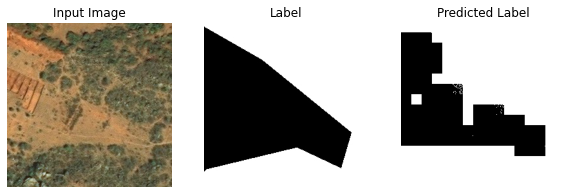


Sample Prediction after epoch 8

127/127 [==============================] - 107s 841ms/step - loss: 0.5746 - iou_coef: 0.6124 - dice_coef: 0.6981 - accuracy: 0.7108 - mse: 0.1917 - val_loss: 0.5277 - val_iou_coef: 0.6395 - val_dice_coef: 0.7219 - val_accuracy: 0.7670 - val_mse: 0.1721 - lr: 0.0010
Epoch 9/50
1/1 [==============================] - 0s 19ms/step


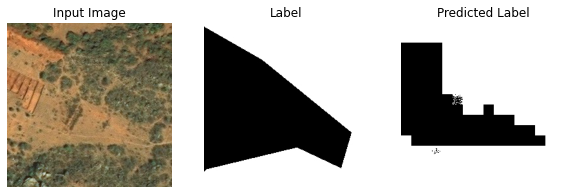


Sample Prediction after epoch 9

127/127 [==============================] - 108s 849ms/step - loss: 0.5612 - iou_coef: 0.6072 - dice_coef: 0.6937 - accuracy: 0.7131 - mse: 0.1864 - val_loss: 0.5309 - val_iou_coef: 0.6420 - val_dice_coef: 0.7240 - val_accuracy: 0.7666 - val_mse: 0.1737 - lr: 0.0010
Epoch 10/50
1/1 [==============================] - 0s 16ms/step


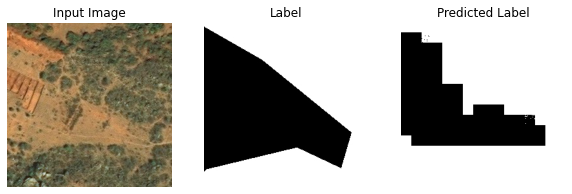


Sample Prediction after epoch 10

127/127 [==============================] - 106s 834ms/step - loss: 0.5467 - iou_coef: 0.6141 - dice_coef: 0.6990 - accuracy: 0.7277 - mse: 0.1800 - val_loss: 0.5100 - val_iou_coef: 0.6468 - val_dice_coef: 0.7284 - val_accuracy: 0.7657 - val_mse: 0.1654 - lr: 0.0010
Epoch 11/50
1/1 [==============================] - 0s 19ms/step


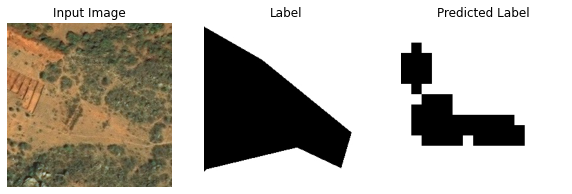


Sample Prediction after epoch 11

127/127 [==============================] - 107s 842ms/step - loss: 0.5442 - iou_coef: 0.6191 - dice_coef: 0.7048 - accuracy: 0.7286 - mse: 0.1789 - val_loss: 0.5119 - val_iou_coef: 0.6547 - val_dice_coef: 0.7362 - val_accuracy: 0.7585 - val_mse: 0.1669 - lr: 0.0010
Epoch 12/50
1/1 [==============================] - 0s 16ms/step


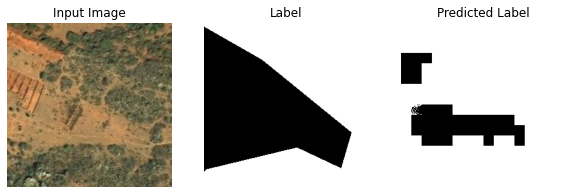


Sample Prediction after epoch 12

127/127 [==============================] - 106s 833ms/step - loss: 0.5378 - iou_coef: 0.6215 - dice_coef: 0.7058 - accuracy: 0.7331 - mse: 0.1763 - val_loss: 0.5136 - val_iou_coef: 0.6568 - val_dice_coef: 0.7384 - val_accuracy: 0.7566 - val_mse: 0.1680 - lr: 0.0010
Epoch 13/50
1/1 [==============================] - 0s 16ms/step


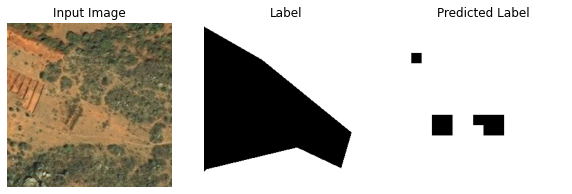


Sample Prediction after epoch 13

127/127 [==============================] - 107s 842ms/step - loss: 0.5286 - iou_coef: 0.6233 - dice_coef: 0.7073 - accuracy: 0.7374 - mse: 0.1727 - val_loss: 0.5507 - val_iou_coef: 0.6558 - val_dice_coef: 0.7377 - val_accuracy: 0.7372 - val_mse: 0.1826 - lr: 0.0010
Epoch 14/50
1/1 [==============================] - 0s 17ms/step


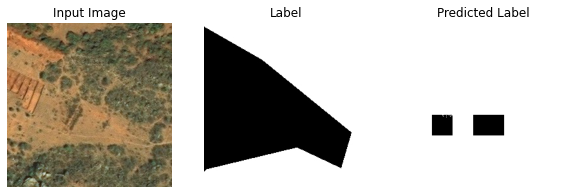


Sample Prediction after epoch 14

127/127 [==============================] - 107s 842ms/step - loss: 0.5280 - iou_coef: 0.6235 - dice_coef: 0.7077 - accuracy: 0.7371 - mse: 0.1726 - val_loss: 0.5481 - val_iou_coef: 0.6545 - val_dice_coef: 0.7364 - val_accuracy: 0.7366 - val_mse: 0.1815 - lr: 0.0010
Epoch 15/50
1/1 [==============================] - 0s 16ms/step


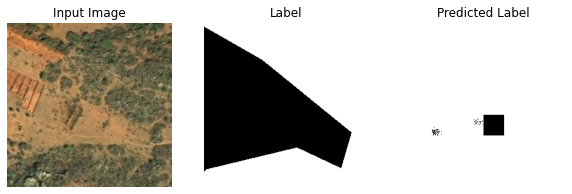


Sample Prediction after epoch 15

127/127 [==============================] - 106s 833ms/step - loss: 0.5217 - iou_coef: 0.6302 - dice_coef: 0.7137 - accuracy: 0.7429 - mse: 0.1698 - val_loss: 0.5579 - val_iou_coef: 0.6563 - val_dice_coef: 0.7383 - val_accuracy: 0.7378 - val_mse: 0.1834 - lr: 0.0010
Epoch 15: early stopping


In [ ]:
# defining some hyperparameters
TRAIN_LENGTH = num_of_training_img
#128
STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE

EPOCHS = 50
TEST_SIZE = num_of_val_img
VALIDATION_STEPS = TEST_SIZE//BATCH_SIZE#//VAL_SUBSPLITS

model_history = model.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_generator,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping]
                          )

In [ ]:
model.evaluate(test_generator, steps=num_of_test_img)

512/512 [==============================] - 125s 245ms/step - loss: 0.5091 - iou_coef: 0.6842 - dice_coef: 0.7657 - accuracy: 0.7606 - mse: 0.1651


[0.5091145634651184,
 0.684192955493927,
 0.7656747698783875,
 0.7606421709060669,
 0.16512450575828552]

1/1 [==============================] - 0s 19ms/step
image shape (1, 256, 256, 3)
mask shape (1, 256, 256, 1)
pred_mask shape (256, 256, 1)


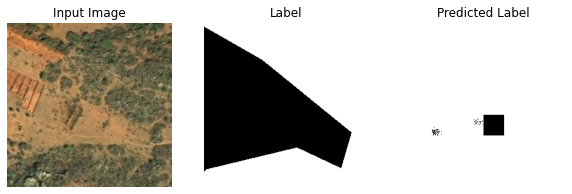

In [ ]:
show_predictions(sample_generator)

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (256, 256, 1)


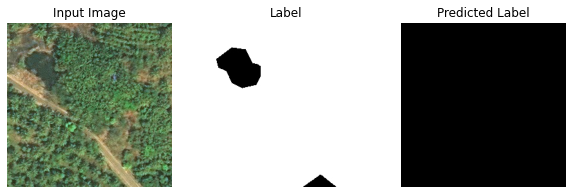

1/1 [==============================] - 0s 27ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (256, 256, 1)


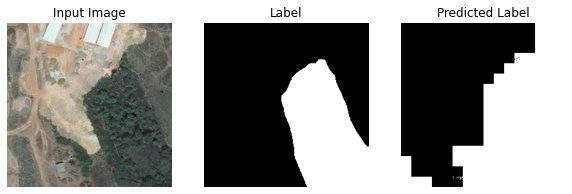

1/1 [==============================] - 0s 27ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (256, 256, 1)


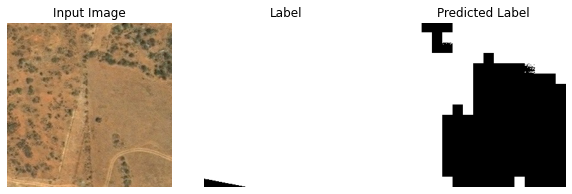

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (256, 256, 1)


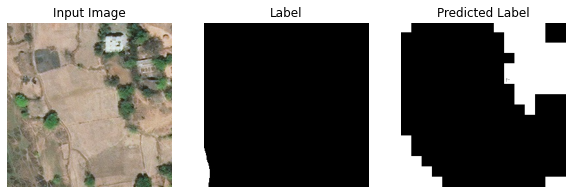

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (256, 256, 1)


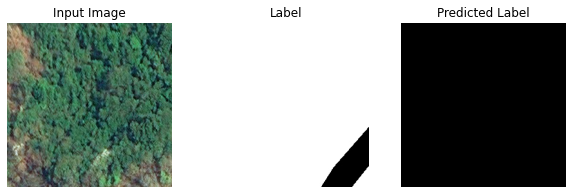

In [ ]:
show_predictions(val_generator, 5)

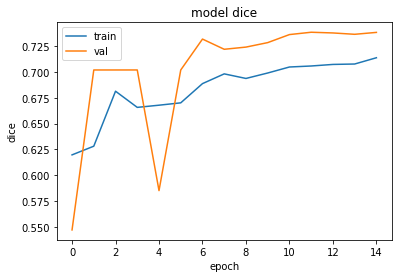

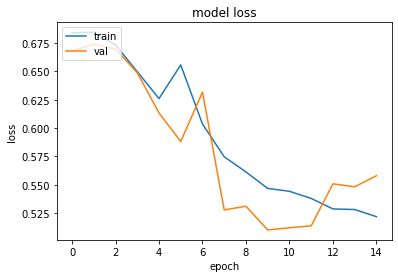

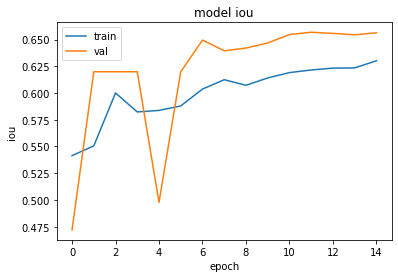

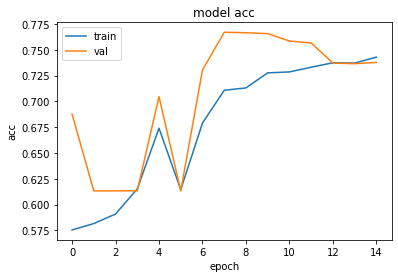

In [ ]:
#dice
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#iou
plt.plot(model_history.history['iou_coef'])
plt.plot(model_history.history['val_iou_coef'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('fcn16-c1-iou-norm.h5')